In [11]:
import torch
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference

## Load tomograms and picks

In [12]:
import numpy as np
from tqdm import tqdm
import copick

copick_config_path = "/hpc/projects/group.czii/kevin.zhao/ml_challenge/example_notebooks/synthetic_data_10439.json" 
root = copick.from_file(copick_config_path)

### Use the rest of 20 tomograms for inference

In [13]:
test_dataset = []
for run in tqdm(root.runs[7:]):
    tomogram = run.get_voxel_spacing(10).get_tomogram('wbp').numpy()
    segmentation = run.get_segmentations(name='paintedPicks', user_id='user0', voxel_size=10, is_multilabel=True)[0].numpy()
    membrane_seg = run.get_segmentations(name='membrane', user_id="data-portal")[0].numpy()
    segmentation[membrane_seg==1]=1 
    test_dataset.append({"image": tomogram, "label": segmentation})

100%|██████████| 20/20 [03:38<00:00, 10.91s/it]


### Create dataloader for the test dataset

In [14]:
from monai.data import DataLoader, CacheDataset
from monai.transforms import (
    Compose, 
    NormalizeIntensityd,
    EnsureChannelFirstd, 
    Activationsd,
    AsDiscreted
)

# define pre transforms
pre_transforms = Compose(
    [   EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        NormalizeIntensityd(keys=["image"]),
])


test_ds = CacheDataset(data=test_dataset, transform=pre_transforms)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


## Load model and weights

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

model.load_state_dict(torch.load("best_metric_model.pth", weights_only=True))
model.eval()

cuda


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 48, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 48, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(48, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.0, inplace=False)
                (A): PReLU(num_pa

## Inference

In [16]:
def inference(model, input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=4,  # one window is proecessed at a time
            predictor=model,
            overlap=0.5,
        )

    with torch.cuda.amp.autocast():
        return _compute(input)

In [17]:
from monai.data import decollate_batch
from tqdm import tqdm

post_transforms = Compose([
            Activationsd(keys="pred", softmax=True),
            AsDiscreted(keys="pred", argmax=True)
])

predictions = []
with torch.no_grad():
    for data in tqdm(test_loader):
        tomogram = data['image'].to(device)  # only support batch=1 and channel first
        data["pred"] = inference(model, tomogram)
        data = [post_transforms(i) for i in decollate_batch(data)]
        for b in data:
            predictions.append(b['pred'].squeeze(0).numpy(force=True))

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_93653/339001617.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 5/5 [00:46<00:00,  9.33s/it]


In [18]:
print(np.unique(predictions[0]))

[0. 2. 3. 4. 5. 6. 7.]


## Visualize the inference results

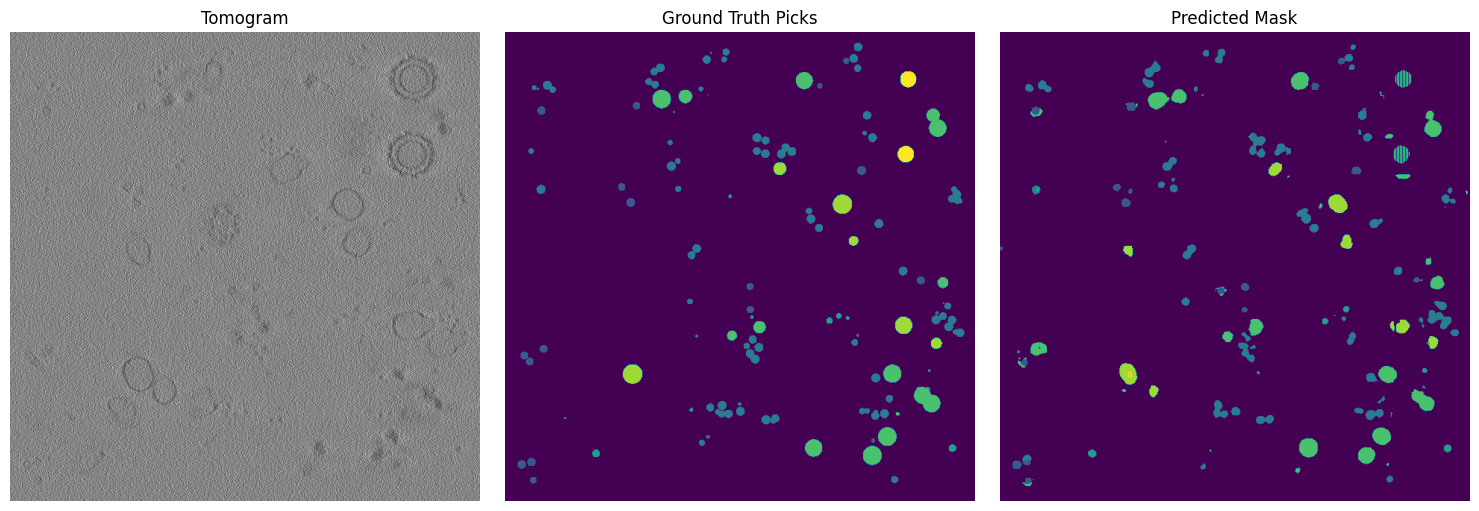

In [19]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Tomogram')
plt.imshow(test_dataset[0]['image'][60], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Picks')
plt.imshow(test_dataset[0]['label'][60], cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predictions[0][60], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

## Get picks from the inference masks, and save them to the copick directory

In [20]:
np.unique(predictions[0])

array([0., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [16]:
import copick_utils
from copick_utils.segmentation.picks_from_segmentation import picks_from_segmentation


particles = dict()
for po in root.config.pickable_objects:
    particles[po.name] = po.label

    
maxima_filter_size = 10
min_particle_size = 0
max_particle_size = 10
new_session_id = "1"
new_user_id = "paintedFromInferencePicks"
for prediction, run in tqdm(zip(predictions, root.runs[7:])):
    for po in particles.keys():
        if po != "membrane":
            class_label = particles[po]
            picks_from_segmentation(prediction, class_label, maxima_filter_size, min_particle_size, max_particle_size, new_session_id, new_user_id, po, run, voxel_spacing=10)